In [5]:
# --- CELDA 1 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore') # Para evitar mensajes molestos de scikit-learn

# 1. Cargar datos
df = pd.read_csv('../movies_dataset.csv')
features = ['popularity', 'vote_count']
target = 'vote_average'

# 2. Limpieza y creación de variable objetivo (1 = Buena, 0 = Mala)
df_clean = df[features + [target]].dropna()
df_clean['clase'] = (df_clean[target] > 6.5).astype(int)

# 3. Tomar una muestra de 500 datos (agiliza el proceso del Notebook)
df_sample = df_clean.iloc[:500].copy()
X = df_sample[features]
y = df_sample['clase']

# 4. Escalar los datos (Crucial para Redes Neuronales)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(f"Dimensiones de los datos escalados: {X_scaled.shape}")
print(f"Distribución de clases:\n{y.value_counts().to_dict()}")

Dimensiones de los datos escalados: (500, 2)
Distribución de clases:
{1: 341, 0: 159}


In [6]:
# --- CELDA 2 ---
error_tc = []
error_tt = []
error_loo = []
error_cv = []

n = X_scaled.shape[0]

for i in range(9):
    # 1. Tabla Completa
    red_tc = MLPClassifier(max_iter=500, random_state=i)
    red_tc.fit(X_scaled, y)
    error_tc.append(1 - red_tc.score(X_scaled, y))

    # 2. Train/Test (70/30)
    X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_scaled, y, test_size=0.3, random_state=i)
    red_tt = MLPClassifier(max_iter=500, random_state=i)
    red_tt.fit(X_train_v, y_train_v)
    error_tt.append(1 - red_tt.score(X_test_v, y_test_v))

    # 3. LOOCV (Leave-One-Out) - Limitado a 100 para no trabar el Jupyter
    errores_loo_acum = 0
    n_loo = min(n, 100) 
    for j in range(n_loo):
        X_train_loo = X_scaled.drop(j, axis=0)
        y_train_loo = y.drop(j, axis=0)
        X_test_loo = X_scaled.iloc[[j]]
        y_test_loo = y.iloc[j]

        red_loo = MLPClassifier(max_iter=200)
        red_loo.fit(X_train_loo, y_train_loo)
        if red_loo.predict(X_test_loo)[0] != y_test_loo:
            errores_loo_acum += 1
    error_loo.append(errores_loo_acum / n_loo)

    # 4. K-Fold CV (10 Folds)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    errores_kf = []
    for train_idx, test_idx in kfold.split(X_scaled, y):
        X_train_kf, X_test_kf = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train_kf, y_test_kf = y.iloc[train_idx], y.iloc[test_idx]
        
        red_kf = MLPClassifier(max_iter=500, random_state=i)
        red_kf.fit(X_train_kf, y_train_kf)
        errores_kf.append(1 - red_kf.score(X_test_kf, y_test_kf))
    error_cv.append(np.mean(errores_kf))
    
    print(f"Iteración {i+1}/9 completada...")

# Crear y mostrar tabla
df_iteraciones = pd.DataFrame({
    'Iteración': [f'Iteración {i+1}' for i in range(9)],
    'Tabla Completa': error_tc,
    'Train/Test': error_tt,
    'LOOCV': error_loo,
    'K-Fold': error_cv
}).set_index('Iteración')

df_iteraciones.loc['PROMEDIO GENERAL'] = df_iteraciones.mean()
display(df_iteraciones.style.format("{:.2%}"))

Iteración 1/9 completada...
Iteración 2/9 completada...
Iteración 3/9 completada...
Iteración 4/9 completada...
Iteración 5/9 completada...
Iteración 6/9 completada...
Iteración 7/9 completada...
Iteración 8/9 completada...
Iteración 9/9 completada...


,Tabla Completa,Train/Test,LOOCV,K-Fold
Iteración,,,,
Iteración 1,20.40%,22.00%,40.00%,25.00%
Iteración 2,20.80%,22.00%,40.00%,23.80%
Iteración 3,19.80%,27.33%,43.00%,23.60%
Iteración 4,19.40%,16.00%,38.00%,24.40%
Iteración 5,19.80%,24.67%,41.00%,22.60%
Iteración 6,20.60%,24.00%,44.00%,24.00%
Iteración 7,20.40%,23.33%,43.00%,24.60%
Iteración 8,20.60%,21.33%,41.00%,23.40%
Iteración 9,20.00%,27.33%,37.00%,23.00%


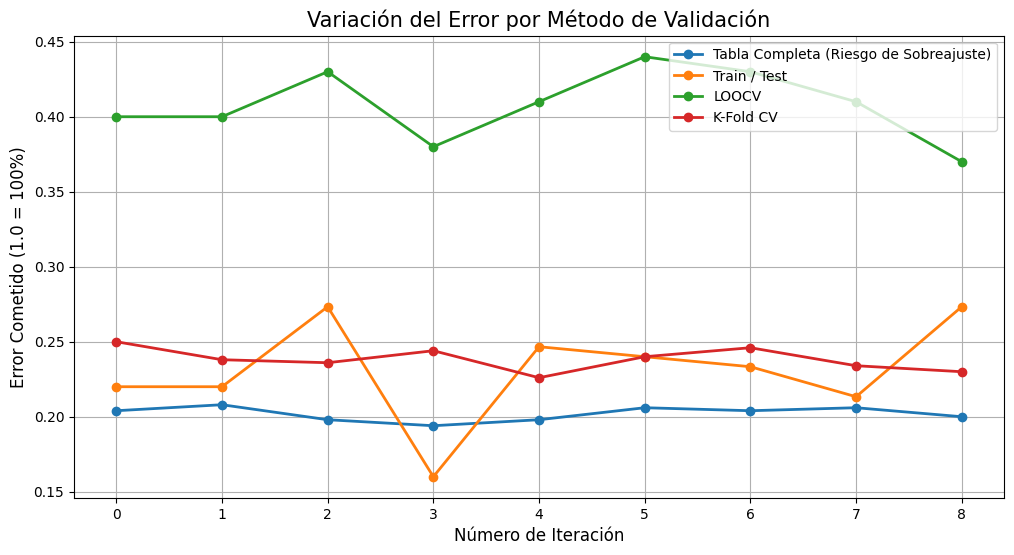

In [7]:
# --- CELDA 3 ---
plt.figure(figsize=(12, 6))

plt.plot(error_tc, 'o-', lw=2, label='Tabla Completa (Riesgo de Sobreajuste)')
plt.plot(error_tt, 'o-', lw=2, label='Train / Test')
plt.plot(error_loo, 'o-', lw=2, label='LOOCV')
plt.plot(error_cv, 'o-', lw=2, label='K-Fold CV')

plt.xlabel("Número de Iteración", fontsize=12)
plt.ylabel("Error Cometido (1.0 = 100%)", fontsize=12)
plt.title("Variación del Error por Método de Validación", fontsize=15)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [8]:
# --- CELDA 4 ---
# Dividimos los datos una vez más de manera estándar para probar métricas
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

modelos = {
    'Red Neuronal (MLP)': MLPClassifier(max_iter=1000, random_state=42),
    'Regresión Logística': LogisticRegression(random_state=42)
}

resumen_metricas = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    resumen_metricas.append({
        'Modelo': nombre,
        'Accuracy (Exactitud)': acc,
        'Precisión': precision_score(y_test, y_pred, zero_division=0),
        'Recall (Exhaustividad)': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'Error Cometido': 1 - acc
    })

df_metricas = pd.DataFrame(resumen_metricas).set_index('Modelo')
print("--- COMPARACIÓN FINAL DE MODELOS ---")
display(df_metricas.style.format("{:.2%}"))

--- COMPARACIÓN FINAL DE MODELOS ---


,Accuracy (Exactitud),Precisión,Recall (Exhaustividad),F1-Score,Error Cometido
Modelo,,,,,
Red Neuronal (MLP),76.00%,82.47%,80.81%,81.63%,24.00%
Regresión Logística,82.00%,86.00%,86.87%,86.43%,18.00%


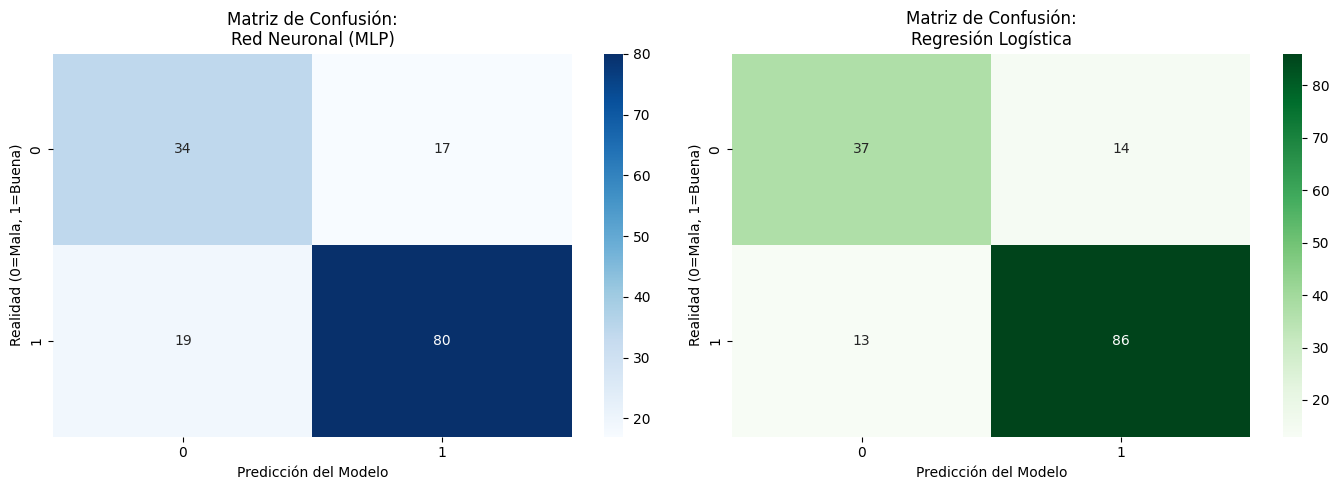

In [9]:
# --- CELDA 5 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (nombre, modelo) in enumerate(modelos.items()):
    y_pred = modelo.predict(X_test) # Reutilizamos los modelos ya entrenados en la Celda 4
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if idx==0 else 'Greens', ax=axes[idx])
    axes[idx].set_title(f'Matriz de Confusión:\n{nombre}')
    axes[idx].set_xlabel('Predicción del Modelo')
    axes[idx].set_ylabel('Realidad (0=Mala, 1=Buena)')

plt.tight_layout()
plt.show()